# Lagrange Point Visualisation

Visualisation of the orbital zones near a planet and a moon - [Lagrange Points](https://en.wikipedia.org/wiki/Lagrange_point)

Based on [Square Planet Gravity](https://github.com/safetydave/maths-whimsy/blob/main/square_planet_gravity.ipynb) - the Numpy V2 version as the most efficient & convenient

Note point approximation of body masses might be far simpler, but here we are... :)

Todo:
* more precise solutions of lagrange points

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

def add_square_body(mass, centre_x, centre_y, delta):
  mass[centre_x - delta:centre_x + delta,
       centre_y - delta:centre_x + delta] = 1.0

def inside(cx, cy, i, j, r):
  dx = i - cx
  dy = j - cy
  return math.sqrt(dx * dx + dy * dy) < r

def add_round_body(mass, centre_x, centre_y, delta):
  # todo meshgrid argwhere
  for i in range(mass.shape[0]):
    for j in range(mass.shape[1]):
      if inside(centre_x, centre_y, i, j, delta):
        mass[i, j] = 1.0

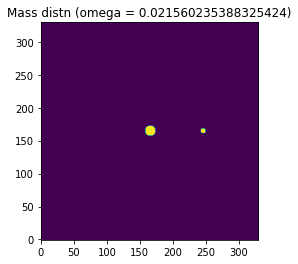

In [2]:
# define the region of space
extent = 330
mass = np.zeros((extent, extent))
centre = extent // 2

# define a planet
planet = 16
add_round_body(mass, centre, centre, planet // 2)
planet_mass = sum(mass.flatten())

# define a moon
moon = 8
orbital_radius = 80
moon_centre = centre + orbital_radius
add_round_body(mass, centre, moon_centre, moon // 2)
total_mass = sum(mass.flatten())
moon_mass = total_mass - planet_mass

# calculate rotation
rotation_centre_x = centre
rotation_centre_y = (planet_mass * centre + moon_mass * moon_centre) / total_mass
omega_moon = math.sqrt(total_mass / math.pow(orbital_radius, 3))
om2 = math.pow(omega_moon, 2)

plt.imshow(mass, origin='lower')
plt.title(f'Mass distn (omega = {omega_moon})')
plt.show()

Meshgrid indexing the region of space

In [3]:
xn = np.linspace(0, extent, extent)
yn = xn.copy()
xng, yng = np.meshgrid(xn, yn)
png = np.stack((xng.flatten(), yng.flatten()), axis=1)
png.shape

(108900, 2)

All points in this indexed region that have mass (currently assumed unit mass - todo repeated points could increase density)

In [4]:
pmg = np.argwhere(mass > 0)
pmg.shape

(238, 2)

Meshgrid for all indexed points in space to feel all points with mass

In [5]:
mi = np.arange(len(pmg))
nj = np.arange(len(png))
mig, njg = np.meshgrid(mi, nj)
pmg[mig].shape, png[njg].shape

((108900, 238, 2), (108900, 238, 2))

Contribution to gravitational field from at a point from a mass

In [6]:
def dgrav_2dv2(pm, pn):
  d = pm - pn
  r = np.hypot(d[:,:,0], d[:,:,1])
  return d / np.power(r, 3).reshape(png.shape[0], pmg.shape[0], 1)

Calculation of centripetal field at a point

In [7]:
c_2d = np.array([rotation_centre_x, rotation_centre_y])

def cptl_2d(pn):
  return (pn - c_2d) * om2 

Gravitational field regional calculation

In [8]:
G = np.apply_along_axis(sum, 1, dgrav_2dv2(pmg[mig], png[njg]))

Centripetal field regional calculation

In [9]:
A = cptl_2d(png)

Resultant field outside of masses

In [10]:
R = G + A

R_grid = R.reshape((extent, extent, 2), order='F')
R_grid[np.nonzero(mass)] = 0

# optionally used for quiver plot
#R_ext = R_grid.reshape((extent * extent, 2))


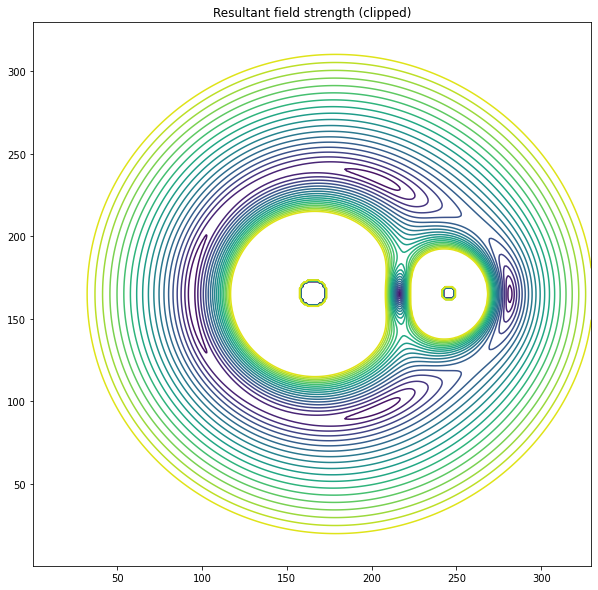

In [11]:
display_delta = centre
field_strength = np.hypot(R_grid[centre - display_delta:centre + display_delta,
                                 centre - display_delta:centre + display_delta, 1],
                          R_grid[centre - display_delta:centre + display_delta,
                                 centre - display_delta:centre + display_delta, 0])
plt.figure(figsize=(10,10))
field_strength_clipped = np.clip(field_strength, 0, 0.06)
plt.contour(field_strength_clipped, 20, origin='lower')
plt.title('Resultant field strength (clipped)')
plt.show()

# For-Loop Version

Note we have to use much smaller numbers for extent, planet & moon here, due to for-loop performance.

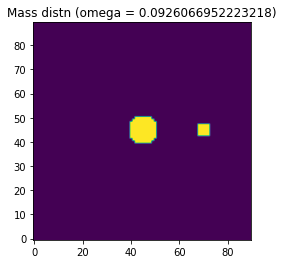

In [12]:
# define the region of space
extent = 90
mass = np.zeros((extent, extent))
centre = extent // 2

# define a planet
planet = 12
add_round_body(mass, centre, centre, planet // 2)
planet_mass = sum(mass.flatten())

# define a moon
moon = 6
orbital_radius = 25
moon_centre = centre + orbital_radius
add_round_body(mass, centre, moon_centre, moon // 2)
total_mass = sum(mass.flatten())
moon_mass = total_mass - planet_mass

# calculate rotation
rotation_centre_x = centre
rotation_centre_y = (planet_mass * centre + moon_mass * moon_centre) / total_mass
omega_moon = math.sqrt(total_mass / math.pow(orbital_radius, 3))
om2 = math.pow(omega_moon, 2)

plt.imshow(mass, origin='lower')
plt.title(f'Mass distn (omega = {omega_moon})')
plt.show()

Calculate gravity vector at each point within the extents, by summing up the influence of all elements of mass within a region. This uses [Newton's Law of Universal Gravitation](https://en.wikipedia.org/wiki/Newton%27s_law_of_universal_gravitation) field equation, with the simplifying assumption that Gm1 = 1, and only calculating in empty space (not inside the planet).

In [13]:
def gravity_point_forloop(region, ip, jp):
  g = np.zeros(2)
  if region[ip, jp] == 0:
    p = np.array([ip, jp])
    for im in range(region.shape[0]):
      for jm in range(region.shape[1]):
        if im == ip and jm == jp or region[im, jm] == 0:
          continue
        dm = np.array([im, jm])    
        d = dm - p
        mag = region[im, jm] / np.dot(d, d)
        g = g + d * mag / np.linalg.norm(d)
  return g

def gravity_field_forloop(region):
  g = np.zeros((region.shape[0], region.shape[1], 2))
  for ip in range(region.shape[0]):
    for jp in range(region.shape[1]):
      g[ip, jp] = gravity_point_forloop(region, ip, jp)
  return g

In [14]:
def centripetal_field_forloop(region, omega):
  af = np.zeros((region.shape[0], region.shape[1], 2))
  c0 = rotation_centre_x
  c1 = rotation_centre_y
  for ip in range(region.shape[0]):
    for jp in range(region.shape[1]):
      if region[ip, jp] == 0:
        af[ip, jp] = np.array([ip - c0, jp - c1]) * om2
  return af

In [15]:
G = gravity_field_forloop(mass)

In [16]:
A = centripetal_field_forloop(mass, omega_moon)

In [17]:
R = G + A
field_strength = np.hypot(R[:,:,1], R[:,:,0])
strength_clipped = np.clip(field_strength, 0, 0.3)

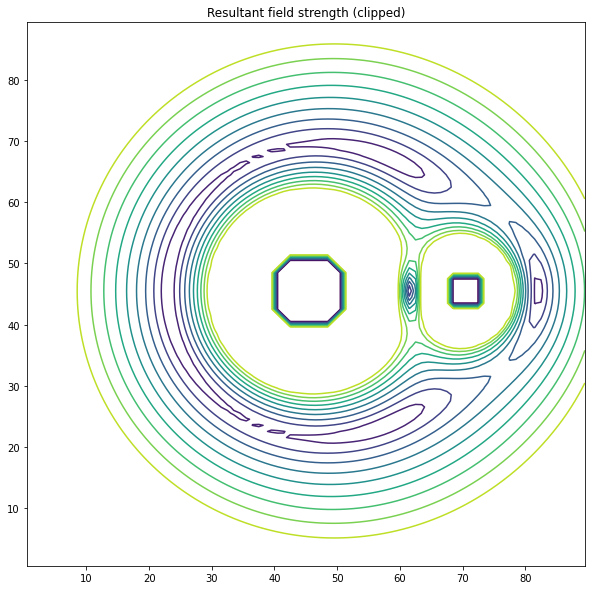

In [18]:
plt.figure(figsize=(10,10))
plt.contour(strength_clipped, 10, origin='lower')
plt.title('Resultant field strength (clipped)')
plt.show()

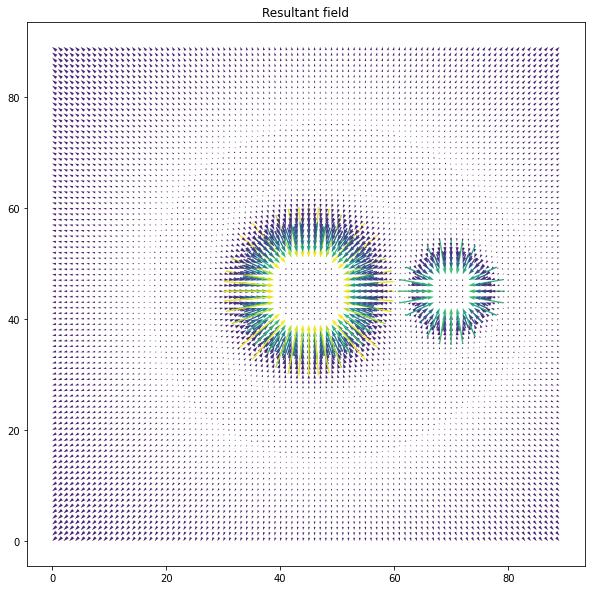

In [19]:
plt.figure(figsize=(10, 10))
plt.quiver(range(R.shape[0]), range(R.shape[1]), R[:,:,1], R[:,:,0], field_strength, pivot='tip')
plt.title('Resultant field')
plt.show()